In [260]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

import en_core_web_md
nlp = en_core_web_md.load()

from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, GlobalAveragePooling1D, Bidirectional, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_hub as hub

In [261]:
df = pd.read_csv('data/spam.csv',encoding='UTF-8')
display(df.head())

df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Apparition de la phrase ```Sorry, I'll call later``` 30 fois

In [262]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [263]:
# Vérification de la valeur v1 pour la phrase
df[df['v2'] == "Sorry, I'll call later"]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
80,ham,"Sorry, I'll call later",NaN,NaN,NaN
222,ham,"Sorry, I'll call later",NaN,NaN,NaN
338,ham,"Sorry, I'll call later",NaN,NaN,NaN
443,ham,"Sorry, I'll call later",NaN,NaN,NaN
701,ham,"Sorry, I'll call later",NaN,NaN,NaN
767,ham,"Sorry, I'll call later",NaN,NaN,NaN
1131,ham,"Sorry, I'll call later",NaN,NaN,NaN
1151,ham,"Sorry, I'll call later",NaN,NaN,NaN
1484,ham,"Sorry, I'll call later",NaN,NaN,NaN
1584,ham,"Sorry, I'll call later",NaN,NaN,NaN


In [264]:
#Suppression de 29 lignes pour pas biaiser les modeles

id_drop = df[df['v2'] == "Sorry, I'll call later"].index
df = df.drop(id_drop[1:], axis=0).reset_index(drop=True)

_v1 : ham or spam_

In [265]:
#Concatenation des colonnes "unnamed" qui correspondent aux messages
cols = ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

df['text'] = df.apply(lambda row: ' '.join(row[cols].dropna().astype(str)), axis=1)
df.drop(cols, axis=1, inplace=True)
df.head()

,v1,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [266]:
print("\nMissing values:\n")
print(df.isnull().sum())


Missing values:

v1      0
text    0
dtype: int64


In [267]:
df_sum = df.groupby(["v1"])['v1'].count().reset_index(name='count')

df_sum.head()

,v1,count
0,ham,4796
1,spam,747


In [268]:
# Pourcentage entre ham et spam
df_sum["percentage"] = round((df_sum["count"] / df_sum["count"].sum()) * 100, 2)
df_sum

,v1,count,percentage
0,ham,4796,86.52
1,spam,747,13.48


In [269]:
fig = px.bar(df_sum, x='v1', y='count', title='Nombre d\'occurrences de ham et spam', color='v1')

fig.show()

On peut observer une _imbalanced_

In [270]:
df["text_length"] = df["text"].apply(len)

fig = px.histogram(df, "text_length", color="v1", barmode="overlay")
fig.show()

Les messages "ham" sont généralement plus long que les spams

## Preprocessing

In [271]:
df.shape
#(5543, 3)

(5543, 3)

In [272]:
df['v1'] = df.v1.map({'ham':0,'spam':1})
df['text_clean'] = df['text'].str.replace(r"[^a-zA-Z0-9&@#_-]+", " ",regex=True) # suppression des caracteres autres que lettre, chiffre ou & @ # _ -
df['text_clean'] = df['text_clean'].fillna('').apply(lambda x: x.lower()) # minuscule

df

,v1,text,text_length,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...
...,...,...,...,...
5538,1,This is the 2nd time we have tried 2 contact u...,161,this is the 2nd time we have tried 2 contact u...
5539,0,Will Ì_ b going to esplanade fr home?,37,will _ b going to esplanade fr home
5540,0,"Pity, * was in mood for that. So...any other s...",57,pity was in mood for that so any other suggest...
5541,0,The guy did some bitching but I acted like i'd...,125,the guy did some bitching but i acted like i d...


In [273]:
# si besoin installer
# python -m spacy download en_core_web_md

# Lemmatisation et STOP_WORDS
df['text_clean'] = df['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

df

,v1,text,text_length,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah don t think usf live
...,...,...,...,...
5538,1,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win 750 pound prize...
5539,0,Will Ì_ b going to esplanade fr home?,37,_ b esplanade fr home
5540,0,"Pity, * was in mood for that. So...any other s...",57,pity mood suggestion
5541,0,The guy did some bitching but I acted like i'd...,125,guy bitch act like d interested buy week free


In [274]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() 
tokenizer.fit_on_texts(df.text_clean)

df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean)

df["len_txt"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_txt"] != 0]

df.head()

,v1,text,text_length,text_clean,text_encoded,len_txt
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3584, 259, 473, 443, 995, 37, 58, 214, 996, 7...",14
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[11, 223, 474, 314, 1, 1521]",6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[14, 323, 3, 564, 660, 27, 1522, 896, 444, 238...",27
3,0,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[1, 136, 167, 2387, 1, 51]",6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah don t think usf live,"[759, 30, 5, 24, 707, 143]",6


In [275]:
df.shape
# Suppression de 19 lignes avec un len_txt = 0

(5524, 6)

In [276]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")
text_pad.shape

(5524, 76)

In [277]:
x_train, x_test, y_train, y_test = train_test_split(text_pad, df.v1, test_size=0.1, random_state=33, stratify=df.v1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=33, stratify=y_train)

In [278]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_batch = train_ds.shuffle(len(train_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)
val_batch = val_ds.shuffle(len(val_ds)).batch(64)

In [279]:
# check du contenu d'un batch

for text, label in train_batch.take(1):
  print(text, label)

tf.Tensor(
[[   2  144 2849 ...    0    0    0]
 [   2    2 2707 ...    0    0    0]
 [   1 2215 1529 ...    0    0    0]
 ...
 [  67    0    0 ...    0    0    0]
 [ 415  277    0 ...    0    0    0]
 [  52   15 1199 ...    0    0    0]], shape=(64, 76), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int64)


In [280]:
# Taux d'apprentissage decroissant
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [281]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True ,
        verbose=1
)

## Baseline

### Embedding simple

Modèles testés :

* 3 couches Dense avec 20 epochs:
    * Couche de prédiction avec sigmoid : ```Epoch 16: early stopping Restoring model weights from the end of the best epoch: 11.```, f1 macro avg = 0.99
    * Couche de prédiction avec softmax : ```Epoch 15: early stopping Restoring model weights from the end of the best epoch: 10.```, f1 macro avg = 0.99
* 5 couches Dense avec 20 epochs:
    * Couche de prédiction avec sigmoid : ```Epoch 17: early stopping Restoring model weights from the end of the best epoch: 12.```, f1 macro avg = 0.99
    * Couche de prédiction avec softmax : ```Epoch 20: early stopping Restoring model weights from the end of the best epoch: 15.```, f1 macro avg = 0.98


Resultat: Juste une petite difference sur le f1 macro avg de 5 couches softmax

In [282]:
output_dim = 128
vocab_size = len(tokenizer.word_counts)
len_texts = text_pad.shape[1]

model_embedding = Sequential()
model_embedding.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim, name="embedding")) # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
model_embedding.add(GlobalAveragePooling1D())
# along each dimension of the representation space.
model_embedding.add(Dense(len_texts, activation='relu')) # a dense layer
model_embedding.add(Dense(80, activation='relu')) # a dense layer
model_embedding.add(Dense(20, activation='relu')) # a dense layer
model_embedding.add(Dense(2, activation='softmax')) # the prediction layer

model_embedding.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [283]:
history = model_embedding.fit(
    train_batch,
    validation_data=val_batch,
    callbacks=[early_stopping],
    epochs=20)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4377 - sparse_categorical_accuracy: 0.8572 - val_loss: 0.3622 - val_sparse_categorical_accuracy: 0.8655
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3814 - sparse_categorical_accuracy: 0.8543 - val_loss: 0.3447 - val_sparse_categorical_accuracy: 0.8655
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3253 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.1672 - val_sparse_categorical_accuracy: 0.9297
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.0691 - val_sparse_categorical_accuracy: 0.9880
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0482 - val_sparse_categorical_accuracy: 0.9880
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.0404 - val_sparse_categorical_accuracy: 0.9920
Epoch 7/20

In [284]:
model_embedding.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 76, 128)        │       948,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 76)             │         9,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 80)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,899,855 (11.06 MB)

 Trainable params: 966,618 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,933,237 (7.37 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


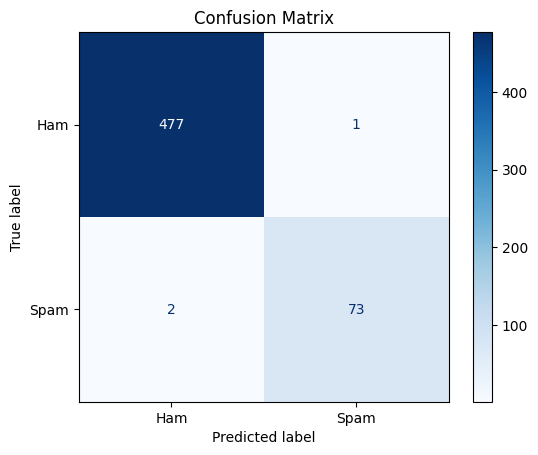

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       0.99      0.97      0.98        75

    accuracy                           0.99       553
   macro avg       0.99      0.99      0.99       553
weighted avg       0.99      0.99      0.99       553



In [285]:
# Evaluate the Model
predictions = model_embedding.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

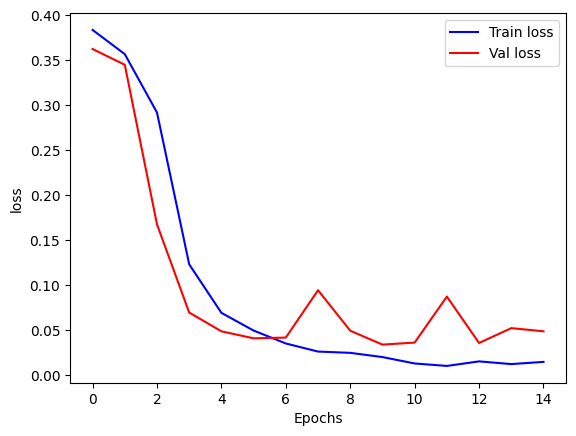

In [286]:
plt.plot(history.history["loss"], color="b", label='Train loss')
plt.plot(history.history["val_loss"], color="r", label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

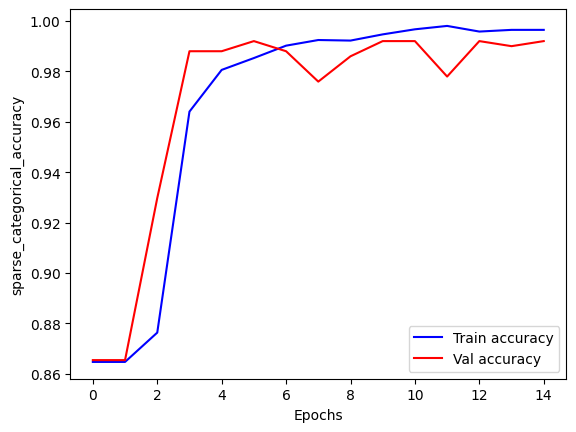

In [287]:
plt.plot(history.history["sparse_categorical_accuracy"], color="b", label='Train accuracy')
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r", label='Val accuracy')
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [288]:
model_embedding.save('./model/model_embedding.keras')

----------------------------------------

### SimpleRNN

Plusieurs tests avec differents parametres, toujours une prediction = ham

In [289]:
output_dim = 128
vocab_size = len(tokenizer.word_counts)

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim, name="embedding"))
model_rnn.add(Bidirectional(SimpleRNN(32)))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer=Adam(learning_rate=lr_schedule), loss=tf.keras.losses.BinaryCrossentropy (), metrics=[tf.keras.metrics.BinaryAccuracy()])

In [290]:
history_rnn = model_rnn.fit(
    train_batch,
    validation_data=val_batch,
    callbacks=[early_stopping],
    epochs=30
    )

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.8765 - loss: 0.3410 - val_binary_accuracy: 0.9799 - val_loss: 0.0693
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.9925 - loss: 0.0391 - val_binary_accuracy: 0.9799 - val_loss: 0.0639
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - binary_accuracy: 0.9973 - loss: 0.0134 - val_binary_accuracy: 0.9859 - val_loss: 0.0537
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.9992 - loss: 0.0060 - val_binary_accuracy: 0.9920 - val_loss: 0.0360
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.9998 - loss: 0.0029 - val_binary_accuracy: 0.9900 - val_loss: 0.0416
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - binary_accuracy: 0.9997 - loss: 0.0020 - val_binary_accuracy: 0.9880 - val_loss: 0.0681
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.9995 - loss: 0.0019 - val_binary_accuracy: 0.9880 - val_loss: 0.0553
Epoch 8/30
70

In [291]:
model_rnn.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 76, 128)        │       948,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        10,304 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,884,228 (11.00 MB)

 Trainable params: 961,409 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,922,819 (7.33 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


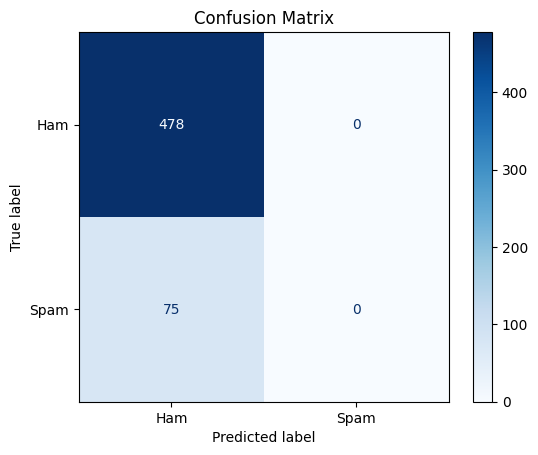

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       478
           1       0.00      0.00      0.00        75

    accuracy                           0.86       553
   macro avg       0.43      0.50      0.46       553
weighted avg       0.75      0.86      0.80       553



c:\Users\DELL\Documents\Formation_Jedha\Project\AT-T_spam_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\DELL\Documents\Formation_Jedha\Project\AT-T_spam_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\DELL\Documents\Formation_Jedha\Project\AT-T_spam_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [292]:
# Evaluate the Model
predictions = model_rnn.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

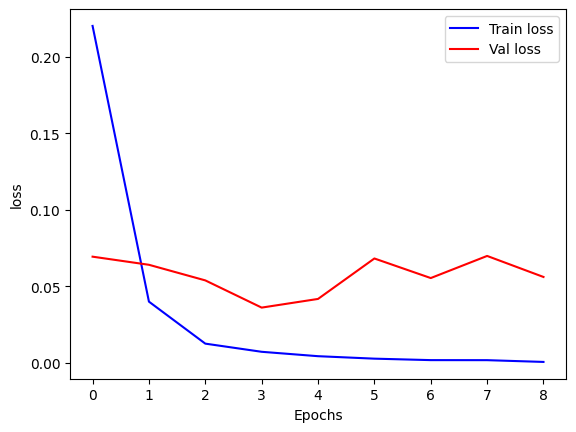

In [293]:
plt.plot(history_rnn.history["loss"], color="b", label='Train loss')
plt.plot(history_rnn.history["val_loss"], color="r", label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

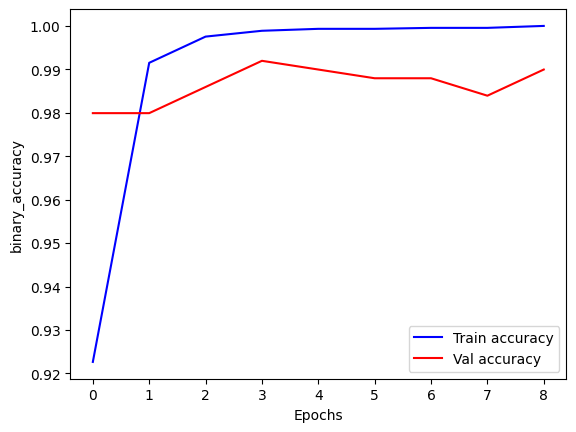

In [294]:
plt.plot(history_rnn.history["binary_accuracy"], color="b", label='Train accuracy')
plt.plot(history_rnn.history["val_binary_accuracy"], color="r", label='Val accuracy')
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()